## Analyze image data from a duckweed genotypes x media growth assay

### How to use this notebook
 - Enter the details requested in part 1
 - In part 2 each cell will execute a different analysis. Feel free to use and modify based on your own needs.
 
 ##### Assumptions made by this notebook
  - Experimental data are a timeseries of images of duckweed growing in 24 plat wells. Image files are stored in the same directory according to the format "exptname_plate_wellID_yyyymmdd.jpg.
  - Experiment metadata are stored in a .json file, with information on which samples and media are in which wells. 

In [35]:
import random
import pandas as pd
import utils.DuckbotExptSetupUtils as exp
import os
import json
import datetime
import pathlib
import re
import numpy as np
import cv2
from PIL import Image, ExifTags
# from plantcv import plantcv as pcv
import matplotlib
import matplotlib.pyplot as plt

import sys, traceback
import cv2
import numpy as np
import argparse
import string
from plantcv import plantcv as pcv

In [92]:

def file_to_datetime(filename):
    no_file_ending = filename.split(".")[0]
    date = no_file_ending[-10:].split("-")
    year = int(date[0])
    month = int(date[1])
    day = int(date[2])
    return year, month, day

def calculate_dpi(y, m, d):
    split_start_date = startdate.split("-")
    y0 = int(split_start_date[0])
    m0 = int(split_start_date[1])
    d0 = int(split_start_date[2])
    start = datetime.datetime(y0, m0, d0)
    end = datetime.datetime(y, m, d)
    diff = (end-start).days
    return(diff)

def find_plate_well_id(filename):
    well_id = re.search('well(.+?)_', filename).group(1) 
    #re.search looks for the string between the (). Within this a '.' indicates any character. '+?'Do something I don't fully understand
    #re.search returns a 'group' of information, which includes the actual matching string at position 0 or 1 depending on the search approach. 
    plate_section_of_string = re.search('late(.+?)_', filename).group(1) #Returns a subsection of the string that has the plate number
    plate_id = re.search('[0-9]', plate_section_of_string).group(0) #[0-9] finds numbers in a string
    return(f'Plate_{plate_id}_Well_{well_id}')

###IMAGE ANALYSIS

#TODO Skip files that are 0Kb

def return_df_with_image_data(img_data_dir, return_df_with_image_data):
    #Add dpi and green pixels
    df = pd.DataFrame(analyze_image_files(img_data_dir, return_df_with_image_data))
    return df

def analyze_image_files(img_data_dir, processed_img_dir_path):
    amount_green = []
    for file in os.listdir(img_data_dir):
        if ".jpg" in file:
            y, m, d = file_to_datetime(file)
            days_post_initiation = calculate_dpi(y, m, d)
            dpi= days_post_initiation
            plant_pixels = calculate_plant_pixels(img_data_dir, file, processed_img_dir_path)   
            amount_green.append({"filename": file, "dpi": dpi, "green_pixels": float(plant_pixels)})
    return(amount_green)

            
    
def calculate_plant_pixels(img_data_dir, file, processed_img_dir_path):
    os.chdir(img_data_dir)
    img, path, filename = pcv.readimage(filename=file)
    pcv.params.debug = False
    roi_contour, roi_hierarchy = pcv.roi.circle(img=img, x=600, y=600, r=500)
    img = pcv.auto_crop(img, roi_contour[0], padding_x=0, padding_y=0, color='black')
#     s = pcv.rgb2gray_hsv(rgb_img=img, channel='h')
    s = pcv.rgb2gray_hsv(img, 's')
    cv2.imwrite(f'{processed_img_dir_path}/{filename}_processed_cropped_grayscale.jpg', s)
    s_thresh = pcv.threshold.binary(s, 85, 255, 'light')
    
    #Remove noise using a blur
    s_mblur = pcv.median_blur(s_thresh, 5)
    s_cnt = pcv.median_blur(s_thresh, 5)
    
    b = pcv.rgb2gray_lab(img, 'b')
    b_thresh = pcv.threshold.binary(b, 160, 255, 'light')
    b_cnt = pcv.threshold.binary(b, 160, 255, 'light')
    
    bs = pcv.logical_or(s_mblur, b_cnt) #Combines blue-yellow thresholding and saturation thresholding

#     s_thresh = pcv.threshold.binary(gray_img=s, threshold=90, max_value=90, object_type='dark')
    cv2.imwrite(f'{processed_img_dir_path}/{filename}_processed_thresholded.jpg', bs)
    masked = pcv.apply_mask(img, mask=bs, mask_color='white')
    cv2.imwrite(f'{processed_img_dir_path}/{filename}_masked_image.jpg', masked)
        # Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
    masked_a = pcv.rgb2gray_lab(masked, 'a')
    masked_b = pcv.rgb2gray_lab(masked, 'b')
    # Threshold the green-magenta and blue images
    maskeda_thresh = pcv.threshold.binary(masked_a, 115, 255, 'dark')
    maskeda_thresh1 = pcv.threshold.binary(masked_a, 135, 255, 'light')
    maskedb_thresh = pcv.threshold.binary(masked_b, 128, 255, 'light')
    # Join the thresholded saturation and blue-yellow images (OR)
    ab1 = pcv.logical_or(maskeda_thresh, maskedb_thresh)
    ab = pcv.logical_or(maskeda_thresh1, ab1)
    # Fill small objects
    ab_fill = pcv.fill(ab, 200)
    cv2.imwrite(f'{processed_img_dir_path}/{filename}_abfill.jpg', ab_fill)
    # Apply mask (for VIS images, mask_color=white)
    masked2 = pcv.apply_mask(masked, ab_fill, 'white')
    cv2.imwrite(f'{processed_img_dir_path}/{filename}_masked2.jpg', masked2)
#     maskeda_thresh = pcv.threshold.binary(gray_img=masked2, threshold=115, max_value=255, object_type='dark')
    masked2_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, max_value=255, object_type='dark')
    cv2.imwrite(f'{processed_img_dir_path}/{filename}_processed_final_version.jpg', masked2_thresh)
    duckweed_pixels = cv2.countNonZero(masked2_thresh)
    return(duckweed_pixels)


def add_data_acrossdfs(input_value, shared_column_name, search_df, desired_column):
    df_subset = search_df[search_df[shared_column_name] == input_value][desired_column] #Find the desired column from the matching part of the search_df
    df_as_list = list(df_subset) #Convert to list to wipe clean the index carried over from search dataframe. 
    desired_value = df_as_list[0] #Specify that we want what should be a single value, rather than a whole list with one entry
    return desired_value


def generate_analysis_df(pixel_df, data_df):
    pixel_df['filename_no_ext'] = pixel_df.apply(lambda row: row.filename[0:-4], axis=1)
    data_df['dpi'] = data_df.apply(lambda row: add_data_acrossdfs(row.filename, 'filename_no_ext', pixel_df, 'dpi'), axis = 1)
    data_df['green_pixels'] = data_df.apply(lambda row: add_data_acrossdfs(row.filename, 'filename_no_ext', pixel_df, 'green_pixels'), axis = 1)

    #Create new dictionary
    analysis_dict = {'genotype': [], 'media' : [], 'dpi' : [], 'green_pixels': []}

    #Populate dictionary with values from dataframe constructed above
    genotype_df = data_df.groupby(['genotype']) #Returns a list of tuples with [0] being the group key and [1] the dataframe
    for g in genotype_df:
        media_df = g[1].groupby(['media'])
        for m in media_df:
            dpi_df = m[1].groupby(['dpi'])
            for d in dpi_df:
                analysis_dict['genotype'].append(list(d[1]['genotype'])[0])
                analysis_dict['media'].append(list(d[1]['media'])[0])
                analysis_dict['dpi'].append(d[0])
                analysis_dict['green_pixels'].append(list(d[1]['green_pixels']))

    #Create dataframe and add medians and standard deviations. 
    analysis_df = pd.DataFrame(analysis_dict)
    analysis_df['median_green_pixels'] = analysis_df.apply(lambda row: np.median(row.green_pixels), axis = 1)
    analysis_df['stdev_green_pixels'] = analysis_df.apply(lambda row: np.std(row.green_pixels), axis = 1)
    return(analysis_df)
    
def plot_media_by_genotype(analysis_df, plot_title):
    genotype = np.unique(analysis_df["genotype"])
    media = np.unique(analysis_df["media"])
    for g in genotype:
        g_df = analysis_df[analysis_df["genotype"] == g]
        fig, ax = plt.subplots(figsize=(40, 20))
        for m in media:
            m_df = g_df[g_df["media"] == m]
            ax.errorbar(m_df['dpi'], m_df["median_green_pixels"],yerr=m_df["stdev_green_pixels"], label=g+"-"+m, linewidth=12)
        ax.legend(loc='upper right',fontsize='xx-large')
        fig.suptitle(f"{plot_title} - {g}", size = 25,wrap = False)
        ax.set_xlabel("Days post Initiation", size = 15)
        ax.set_ylabel("Frond area (pixels)", size = 15)
        fig.show()


### Part 1 - Define filenames and paths

In [37]:

#Where is the Json file with the experiment metadata and what is it called?
# metadata_dir =  "/home/delangeo/duckbot_git_clone/duckbot/test_data/TestExptDir/" #'/Users/Orlando/Documents/Github_clones/duckbot/test_data/TestExptDir/'
# metadata_filename = 'TestFile.json'
metadata_path = "/Users/Orlando/Documents/Github_clones/duckbot/notebooks/TestDriveExpt_1_08032022/TestDriveExpt_1_08032022.json"

#Where are the image files that you want to analyze and what is the experiment ID (should be first part of each image filename)
img_data_host_dir_path = "/Users/Orlando/Documents/Github_clones/duckbot/test_data/" #"/Users/Orlando/Documents/Github_clones/duckbot/test_data/odl_dataanalaysistest1"
img_data_dir = "TestDriveExpt_1_08032022"
img_data_dir_path = img_data_host_dir_path + img_data_dir

#Processed image directory. Will save outputs of image processing workflow in case you want to visually inspect
processed_img_dir_path = img_data_host_dir_path + img_data_dir + "_processed"
if not os.path.exists(processed_img_dir_path):
    os.mkdir(processed_img_dir_path)     

#Where do you want the figures produced by this script to end up?
output_figure_dir = "/Users/Orlando/Documents/Github_clones/duckbot/test_data/"#'/Users/Orlando/Documents/Github_clones/duckbot/test_data/'

#What was day 0 for this experiment in format (yyyy-mm-dd)
startdate = "2022-08-03"

### Part 2 - Building a dataframe with percentage duckweed coverage in each image

In [44]:
p = pathlib.Path(img_data_dir_path)   # current directory, insert your directory here
data_filenames = [x.stem for x in p.glob('*.jpg')]
data_df = pd.DataFrame({"filename": data_filenames})
data_df['plate_well_id'] = data_df.apply(lambda row: find_plate_well_id(row.filename), axis=1)
data_df['date'] = data_df.apply(lambda row: row.filename[-10:], axis=1)

In [45]:
#Processing images
with open(metadata_path) as metadata:
    expt_data = json.load(metadata)

plate_set_up = expt_data["sample_info"]
md_df = pd.DataFrame(plate_set_up)

In [46]:
# Populate and then Rearrange a dataframe for data analysis

#Add metadata columns
data_df['media'] = data_df.apply(lambda row: add_data_acrossdfs(row.plate_well_id, 'plate_well_id', md_df, 'media'), axis=1)
data_df['genotype'] = data_df.apply(lambda row: add_data_acrossdfs(row.plate_well_id, 'plate_well_id', md_df, 'genotype'), axis=1)
data_df['replicate'] = data_df.apply(lambda row: add_data_acrossdfs(row.plate_well_id, 'plate_well_id', md_df, 'condition_replicate'), axis=1)

In [93]:
#Plant CV pixel counts
pixel_df = return_df_with_image_data(img_data_dir_path, processed_img_dir_path)
print(pixel_df)

                                              filename  dpi  green_pixels
0    TestDriveExpt_1_08032022_Plate_1_wellB1_2022-0...    9        2754.0
1    TestDriveExpt_1_08032022_Plate_1_wellC4_2022-0...    9      138982.0
2    TestDriveExpt_1_08032022_Plate_1_wellA2_2022-0...    6       20059.0
3    TestDriveExpt_1_08032022_Plate_2_wellB5_2022-0...    6       50454.0
4    TestDriveExpt_1_08032022_Plate_2_wellA6_2022-0...    9      124609.0
..                                                 ...  ...           ...
174  TestDriveExpt_1_08032022_Plate_1_wellA5_2022-0...    4       66544.0
175  TestDriveExpt_1_08032022_Plate_1_wellA2_2022-0...    1           0.0
176  TestDriveExpt_1_08032022_Plate_2_wellB2_2022-0...    4           0.0
177  TestDriveExpt_1_08032022_plate1_wellC6_2022-08...    0       39096.0
178  TestDriveExpt_1_08032022_plate1_wellB3_2022-08...    0       75877.0

[179 rows x 3 columns]


### Part 3 - Produce figures

#### Data display option - Growth curves
Connects datapoints averaged across replicates to produce a line of growth against time. 

/var/folders/nc/pbz0zfmn5tq28c62lh3svf880000gn/T/ipykernel_1690/3440418939.py:141: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


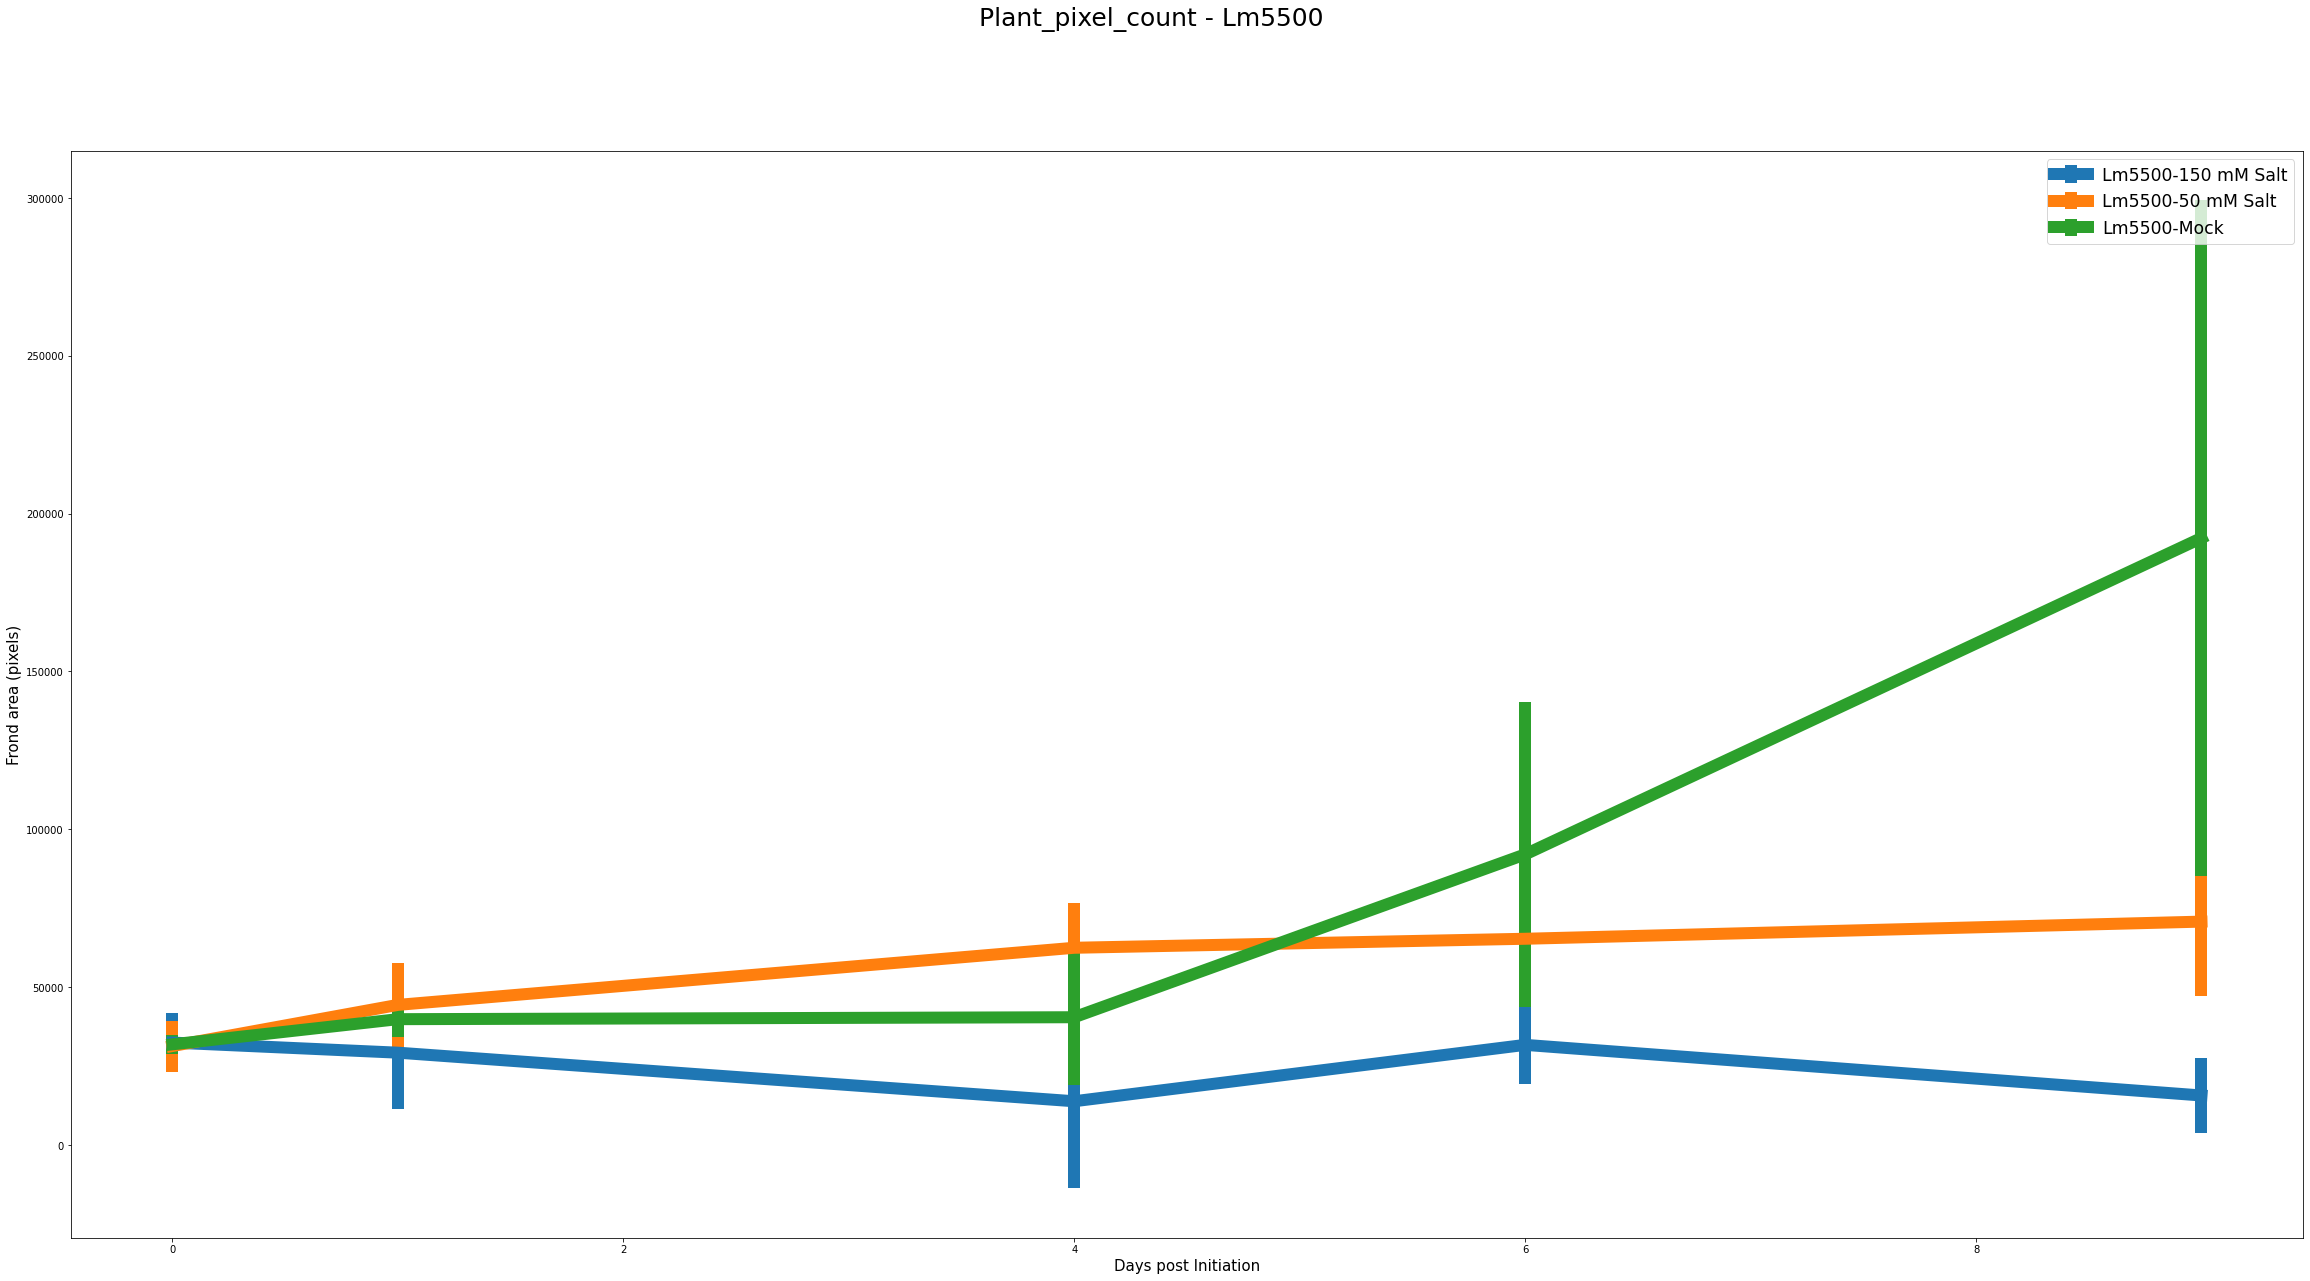

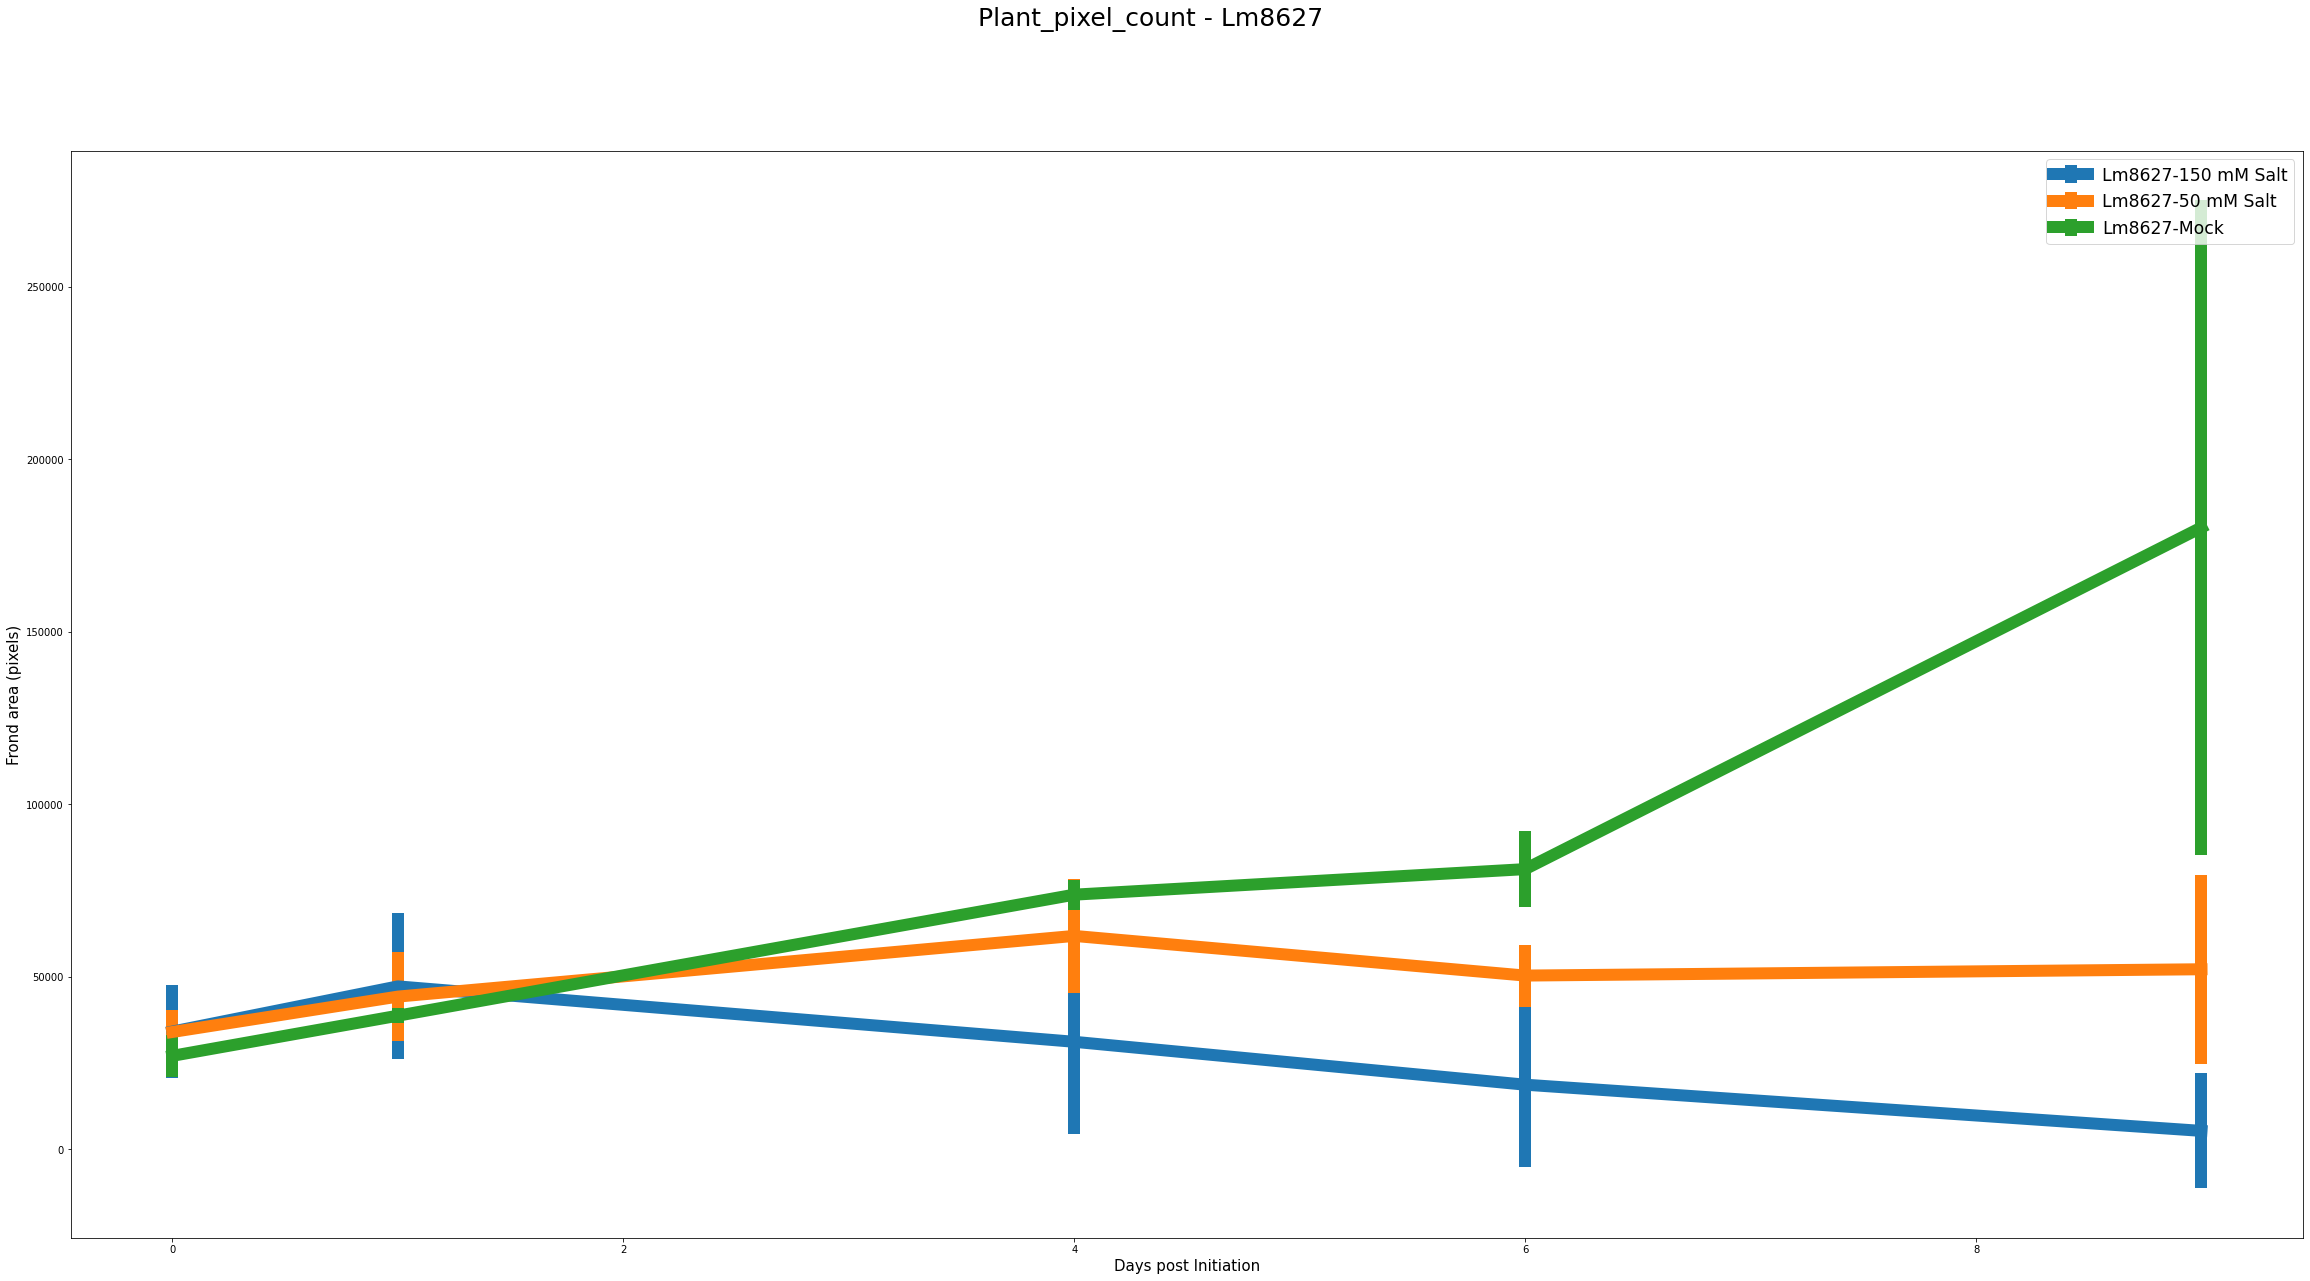

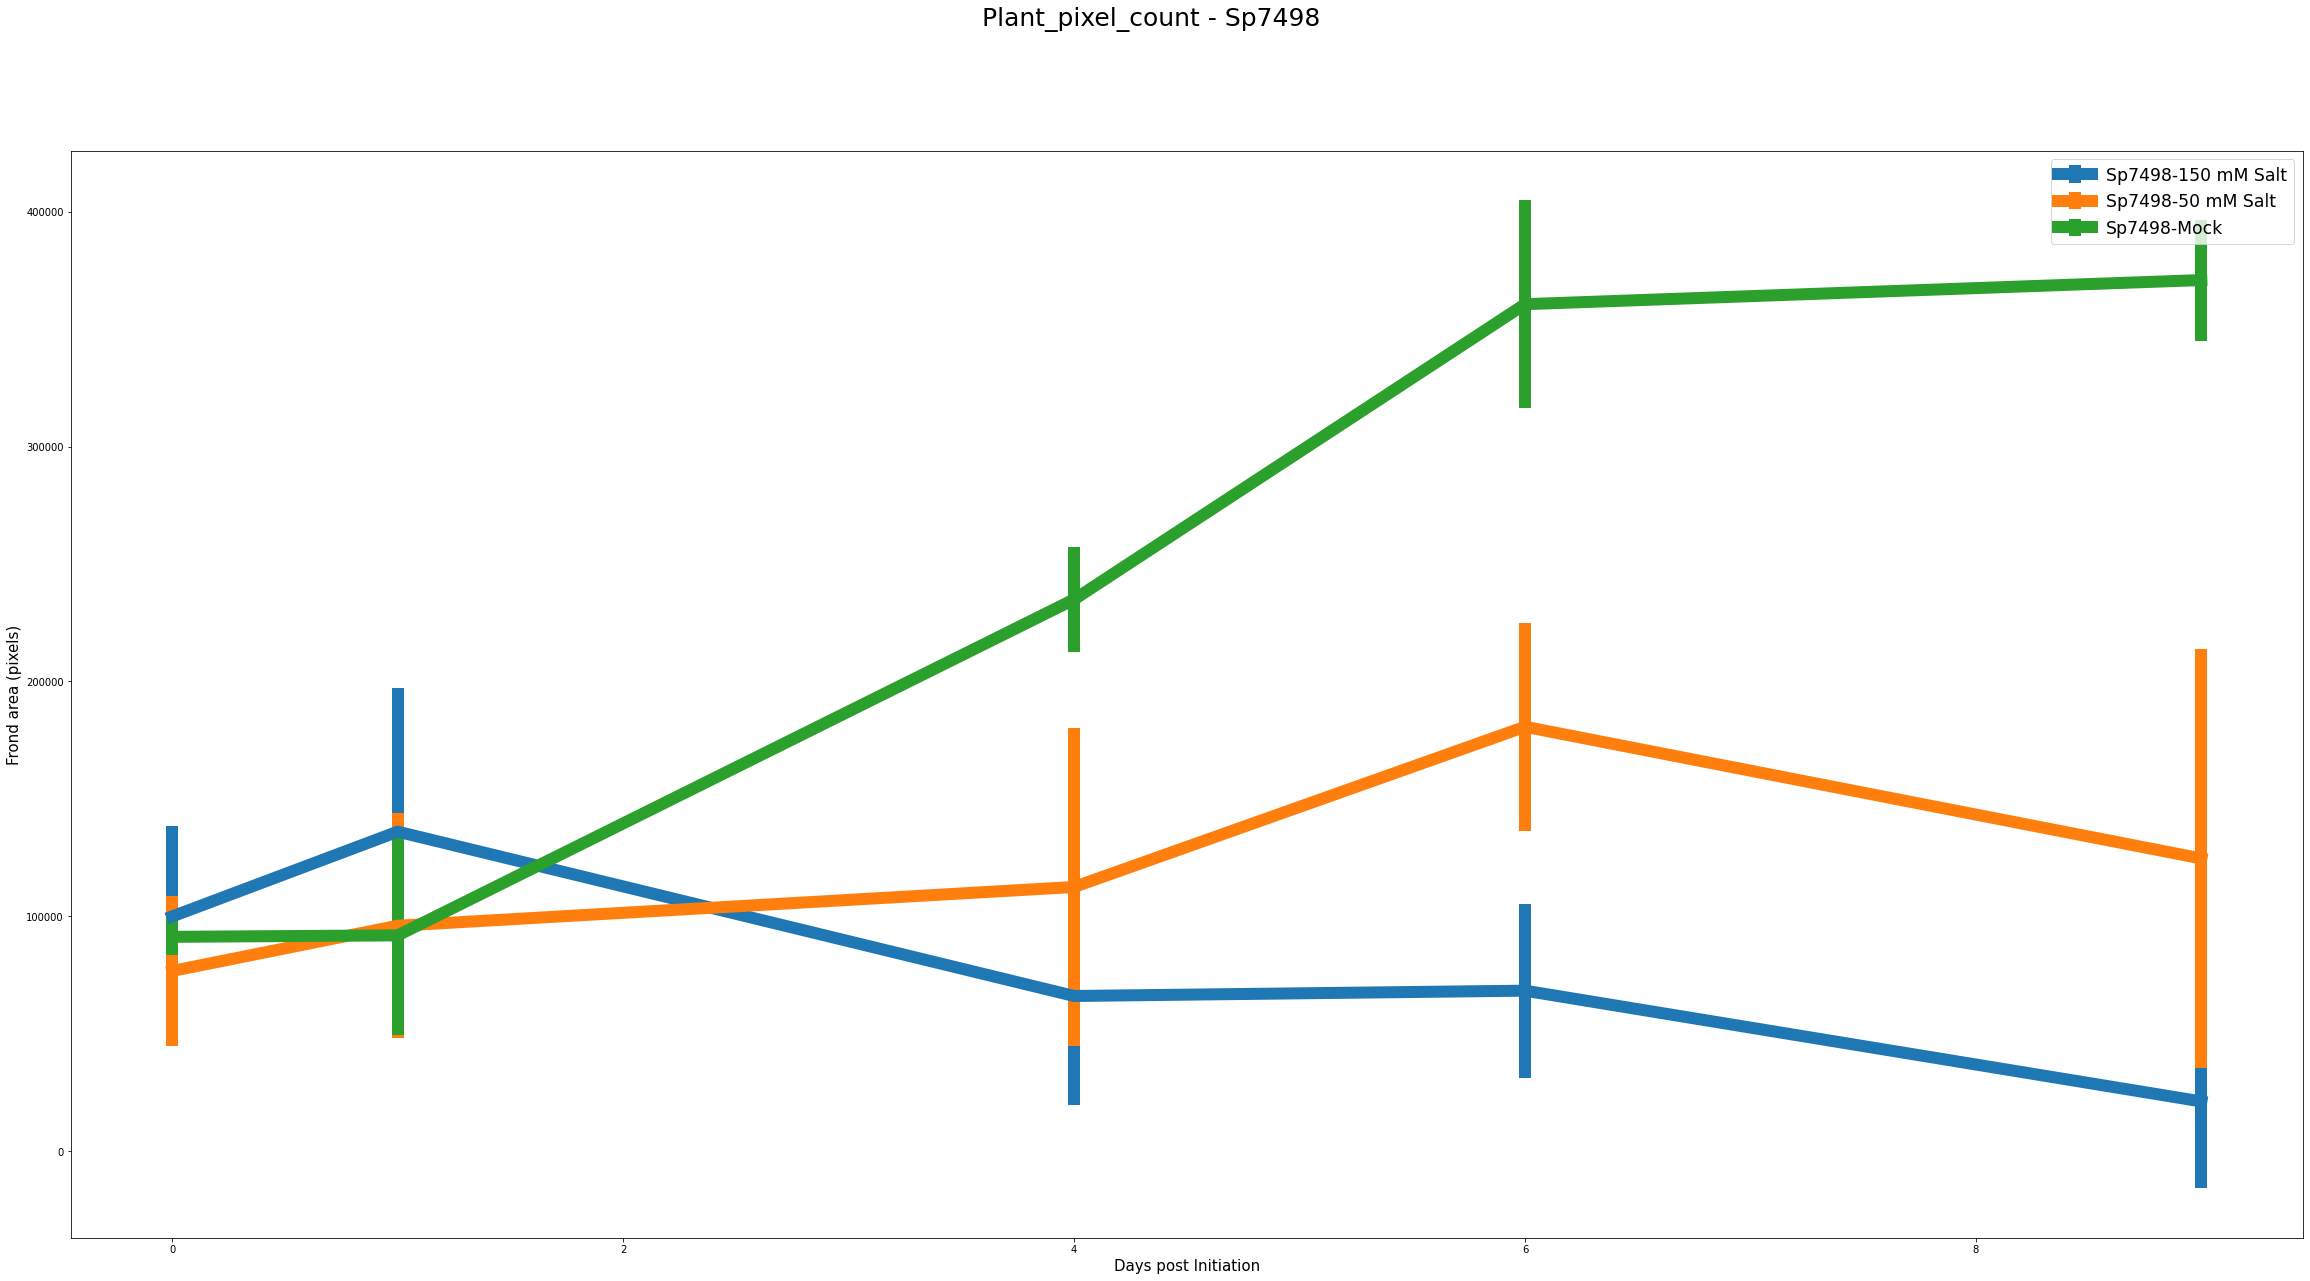

In [94]:
#Green pixel counting pixel counts
analysis_df = generate_analysis_df(pixel_df, data_df)
plot_media_by_genotype(analysis_df, "Plant_pixel_count")

### Data display option - Dose Response curve
Note that this analylsis only makes sense if your experiment involved a series of media conditions along a quantitative axis (i.e. concentration of a particular additive). 

In [195]:

xdata = list(cond_dict.keys())
ydata = [cond_dict[cond][4]/cond_dict[cond][0] for cond in xdata]

def residual(params, x, y):
    def f(x):
        return (params['L']/(1.0 + math.e**(-1*params['k']*(x-params['x0']))))
    yval = f(x)
    errs = [abs((a-b)) for a, b in zip(y, yval)]
    return errs

#depending on the data, need to go thru and refine the starting conditions
p = Parameters()
p.add('L', value=max(ydata))
p.add('k', value=.01)
p.add('x0', value=xdata[-1]/2)


result = minimize(residual,p,args=(xdata,ydata))
result.params.pretty_print()


xvals = np.linspace(0,max(xdata),420)
plt.plot(xvals,(result.params['L'] /(1.0 + math.e**(-1*result.params['k']*(xvals-result.params['x0'])))), c = 'black')

plt.text(230, 1.95, "L = %.2f\nk = %.2f\nx0 = %.2f" % (result.params['L'], result.params['k'], result.params['x0']))
plt.xlabel("NaCl Concentration (mM)")
plt.ylabel("Normalized Growth Over 10 Days")
plt.scatter(xdata,ydata, c = 'black')
plt.savefig("dose_response_4c.jpg")


NameError: name 'cond_dict' is not defined

#### Part 2


In [ ]:
#